# Kubeflow Pipelines e2e mnist example

In this notebook you will create Kubeflow Pipeline to perfom:
- Hyperparameter tuning using Katib
- Distributive training with the best hyperparameters using TFJob
- Serve the trained model using KFServing

Reference documentation:

- https://www.kubeflow.org/docs/components/training/tftraining/
- https://www.kubeflow.org/docs/components/katib/
- https://www.kubeflow.org/docs/components/kfserving/

**Note**: This Pipeline runs in multi-user mode. To run this Pipeline your Notebook should have the appropriate PodDefault with pipelines.kubeflow.org audience. For more information, check this comment: https://github.com/kubeflow/pipelines/issues/5138#issuecomment-797003710.

In [1]:
!pip install kfp==1.4.0
!pip install kubeflow-katib==0.10.1

     |████████████████████████████████| 159 kB 22.4 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 6.8 MB/s  eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 5.9 MB/s  eta 0:00:01
  Created wheel for kfp: filename=kfp-1.4.0-py3-none-any.whl size=221064 sha256=6d00f4556036892252a75b303cdc3475ed68a4bd10400dcaa50a42ddb7d2d2a2
  Stored in directory: /home/jovyan/.cache/pip/wheels/32/d3/f4/391718189ca330738e29d3506fa0c4cc5960f48be177df94bb
  Created wheel for docstring-parser: filename=docstring_parser-0.7.3-py3-none-any.whl size=19230 sha256=f7abcd4a033911a5608b949bc76b137338f9784bdbee79180d57b14d3dcc00f6
  Stored in directory: /home/jovyan/.cache/pip/wheels/ce/24/c5/20e7ab5fee45d176ff81a87f73cc8bb4cfca9f28e56c96d62c
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=afb1d7c9b2185d7d63a6b2f2dd6adf9bc9582f0d

In [206]:
import kfp
import kfp.dsl as dsl
from kfp import components

from kubeflow.katib import ApiClient
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

## Define the Pipelines tasks

To run this Pipeline, you should define:
1. Katib Experiment.
2. TFJob object
3. KFServing inference



### Step 1. Katib hyperparameter tuning task

Create the Kubeflow Pipelines task for the Katib hyperparameter tuning. This Experiment uses "random" algorithm and TFJob for the Trial's worker.

The Katib Experiment is similar to this example: https://github.com/kubeflow/katib/blob/master/examples/v1beta1/tfjob-example.yaml.

In [281]:
# You should define the Experiment name, namespace and number of training steps in the arguments.
def create_katib_experiment_task(experiment_name, experiment_namespace, training_steps):
    # Trial count specification.
    max_trial_count = 1
    max_failed_trial_count = 3
    parallel_trial_count = 1

    # Objective specification.
    objective = V1beta1ObjectiveSpec(
        type="minimize",
        goal=0.001,
        objective_metric_name="loss"
    )

    # Algorithm specification.
    algorithm = V1beta1AlgorithmSpec(
        algorithm_name="random",
    )

    # Experiment search space.
    # In this example we tune learning rate and batch size.
    parameters = [
        V1beta1ParameterSpec(
            name="learning_rate",
            parameter_type="double",
            feasible_space=V1beta1FeasibleSpace(
                min="0.01",
                max="0.05"
            ),
        ),
        V1beta1ParameterSpec(
            name="batch_size",
            parameter_type="int",
            feasible_space=V1beta1FeasibleSpace(
                min="80",
                max="100"
            ),
        )
    ]

    # Experiment Trial template.
    # TODO (andreyvelich): Use community image for the mnist example.
    trial_spec = {
        "apiVersion": "kubeflow.org/v1",
        "kind": "TFJob",
        "spec": {
            "tfReplicaSpecs": {
                "Chief": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                },
                "Worker": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                }
            }
        }
    }

    # Configure parameters for the Trial template.
    trial_template = V1beta1TrialTemplate(
        primary_container_name="tensorflow",
        trial_parameters=[
            V1beta1TrialParameterSpec(
                name="learningRate",
                description="Learning rate for the training model",
                reference="learning_rate"
            ),
            V1beta1TrialParameterSpec(
                name="batchSize",
                description="Batch size for the model",
                reference="batch_size"
            ),
        ],
        trial_spec=trial_spec
    )

    # Create an experiment from the above parameters.
    experiment_spec = V1beta1ExperimentSpec(
        max_trial_count=max_trial_count,
        max_failed_trial_count=max_failed_trial_count,
        parallel_trial_count=parallel_trial_count,
        objective=objective,
        algorithm=algorithm,
        parameters=parameters,
        trial_template=trial_template
    )

    # Create the KFP task for Katib Experiment.
    # Experiment Spec should be serialized to a valid Kubernetes object.
    katib_experiment_launcher_op = components.load_component_from_url(
        "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml")
    op = katib_experiment_launcher_op(
        experiment_name=experiment_name,
        experiment_namespace=experiment_namespace,
        experiment_spec=ApiClient().sanitize_for_serialization(experiment_spec),
        experiment_timeout_minutes=60,
        delete_finished_experiment=False)

    return op

### Step 2. TFJob training task

Create the Kubeflow Pipelines task for the TFJob training. In this example TFJob runs the Chief and Worker with 2 replicas.

Learn more about TFJob replica specifications in the Kubeflow docs: https://www.kubeflow.org/docs/components/training/tftraining/#what-is-tfjob.

In [282]:
# This function converts Katib Experiment HP results to args.
def convert_katib_results(katib_results) -> str:
    import json
    import pprint
    katib_results_json = json.loads(katib_results)
    print("Katib results:")
    pprint.pprint(katib_results_json)
    best_hps = []
    for pa in katib_results_json["currentOptimalTrial"]["parameterAssignments"]:
        if pa["name"] == "learning_rate":
            best_hps.append("--tf-learning-rate=" + pa["value"])
        elif pa["name"] == "batch_size":
            best_hps.append("--tf-batch-size=" + pa["value"])
    print("Best Hyperparameters: {}".format(best_hps))
    return " ".join(best_hps)

In [283]:
# You should define TFJob name, namespace, number of training steps and output of Katib task in the arguments.
def create_tfjob_task(tfjob_name, tfjob_namespace, training_steps, katib_op, model_volume_op):
    import json
    # Get parameters from the Katib Experiment.
    # Parameters are in the format "--tf-learning-rate=0.01 --tf-batch-size=100"
    convert_katib_results_op = components.func_to_container_op(convert_katib_results)
    best_hp_op = convert_katib_results_op(katib_op.output)
    best_hps = str(best_hp_op.output)

    # Create the TFJob Chief and Worker specification with the best Hyperparameters.
    # TODO (andreyvelich): Use community image for the mnist example.
    tfjob_chief_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c"
                        ],
                        "args": [
                            "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps=200 " + best_hps
                        ],
                        "volumeMounts": [
                            {
                                "mountPath": "/mnt/export",
                                "name": "model-volume"
                            }
                        ]
                    }
                ],
                "volumes": [
                    {
                        "name": "model-volume",
                        "persistentVolumeClaim": {
                            "claimName": str(model_volume_op.outputs["name"])
                        }
                    }
                ]
            }
        }
    }

    tfjob_worker_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c",
                        ],
                        "args": [
                          "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps=200 " + best_hps 
                        ],
                    }
                ],
            }
        }
    }

    # Create the KFP task for TFJob.
    tfjob_launcher_op = components.load_component_from_url(
        "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/launcher/component.yaml")
    op = tfjob_launcher_op(
        name=tfjob_name,
        namespace=tfjob_namespace,
        chief_spec=json.dumps(tfjob_chief_spec),
        worker_spec=json.dumps(tfjob_worker_spec),
        tfjob_timeout_minutes=60,
        delete_finished_tfjob=False)
    return op

### Step 3. KFServing inference

Create the Kubeflow Pipelines task for the KFServing inference.

In [302]:
def create_kfserving_task(model_name, model_namespace, model_volume_op, tfjob_op):

    inference_service = '''
apiVersion: "serving.kubeflow.org/v1beta1"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
  annotations:
    "sidecar.istio.io/inject": "false"
spec:
  predictor:
    tensorflow:
      storageUri: "pvc://{}/"
'''.format(model_name, model_namespace, str(model_volume_op.outputs["name"]))
    

    kfserving_launcher_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/kfserving/component.yaml')
    kfserving_launcher_op(action="create", inferenceservice_yaml=inference_service).after(tfjob_op)
    

## Run the Kubeflow Pipeline

You should create the Kubeflow Pipeline with the above tasks.

In [303]:
name="mnist-e2e"
namespace="kubeflow-user"
training_steps="200"

@dsl.pipeline(
    name="End to end Pipeline",
    description="An end to end mnist example including hyperparameter tuning, train and inference"
)
def mnist_pipeline(name=name, namespace=namespace, training_steps=training_steps):
    # Run the hyperparameter tuning with Katib.
    katib_op = create_katib_experiment_task(name, namespace, training_steps)

    # Create volume to train and serve model.
    model_volume_op = dsl.VolumeOp(
        name="model-volume",
        resource_name="model-volume",
        size="1Gi",
        modes=dsl.VOLUME_MODE_RWO
    )

    # Run distributive training using TFJob.
    tfjob_op = create_tfjob_task(name, namespace, training_steps, katib_op, model_volume_op)

    # Create KFServing inference.
    create_kfserving_task(name, namespace, model_volume_op, tfjob_op)

# Run the Kubeflow Pipeline in the user's namespace.
kfp_client=kfp.Client()
run_id = kfp_client.create_run_from_pipeline_func(mnist_pipeline, namespace=namespace, arguments={}).run_id
print("Run ID: ", run_id)

Run ID:  0f2b2ad0-d67a-4daa-870c-1e654ba1c7de


The finished Pipeline should look as follows.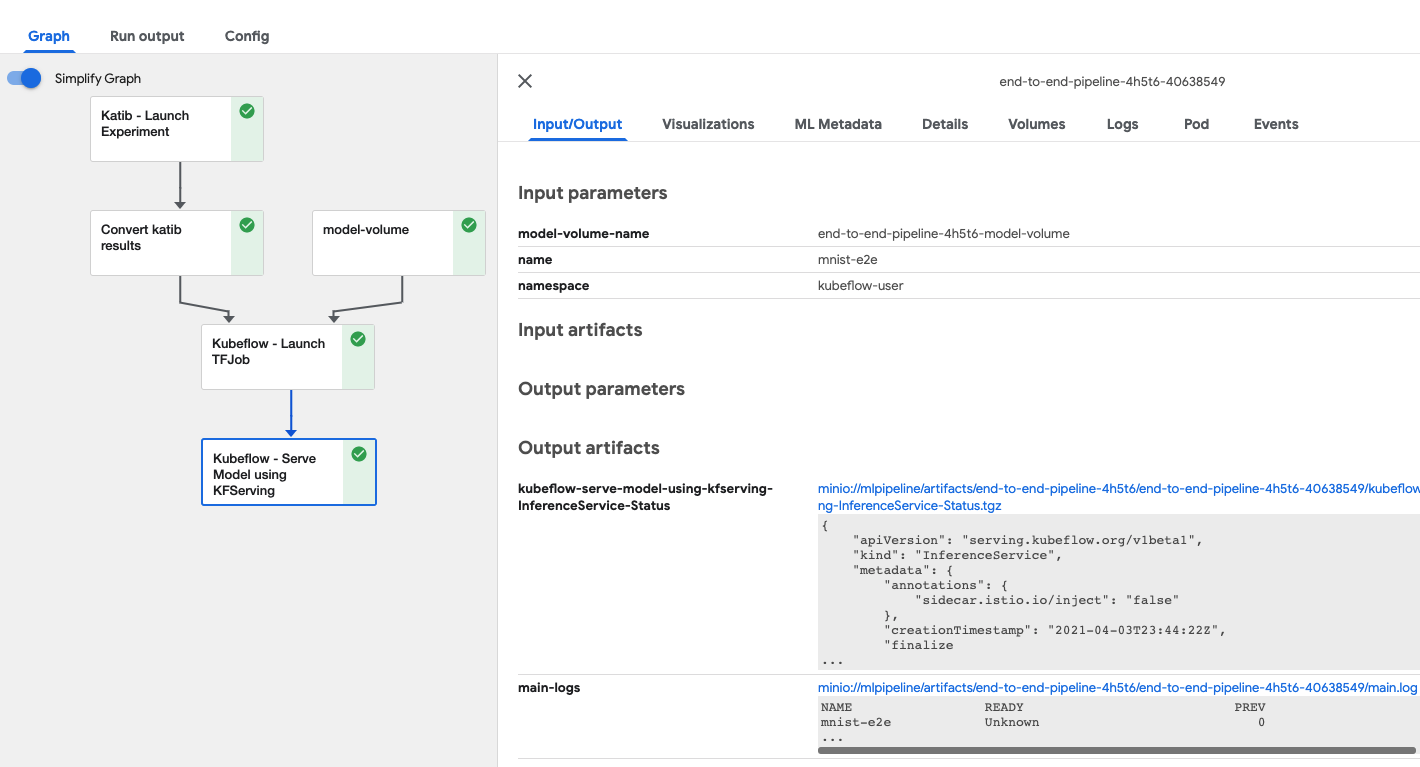

## Predict from the trained model

Once Kubeflow Pipeline is finished you are able to call API endpoint to predict from the trained model.
Upload a mnist picture to your notebook, such as `9.bmp` from [here]()

**Note**: If you are using Kubeflow + Dex setup and not runing this Notebook in your Kubernetes cluster, follow [this guide](https://github.com/kubeflow/kfserving/tree/master/docs/samples/istio-dex#authentication) to get Session ID for requests.

In [333]:
import numpy as np
from PIL import Image
import requests

# Pipeline Run should be succeeded.
kfp_run = kfp_client.get_run(run_id=run_id)
if kfp_run.run.status == "Succeeded":
    print("Run {} has been Succeeded".format(run_id))
    image_file = "9.bmp"
    data = np.array(Image.open(image_file).convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)
    np.set_printoptions(threshold=np.inf)
    json_request = '{{ "instances" : {} }}'.format(np.array2string(data, separator=',', formatter={'float':lambda x: "%.1f" % x}))
#     print(json_request)
#     headers={"Cookie": "authservice_session=eyJhbGciOiJSUzI1NiIsImtpZCI6IjBHWG14WEdZVEoxeWNJWU5IcGRXVndMZWl1aDJMc2N2M2k4M3g3V3BtUzQifQ.eyJhdWQiOlsibWwtcGlwZWxpbmUiXSwiZXhwIjoxNjE3NDk5MzA4LCJpYXQiOjE2MTc0OTIxMDgsImlzcyI6Imh0dHBzOi8vY29udGFpbmVyLmdvb2dsZWFwaXMuY29tL3YxL3Byb2plY3RzL2Nwc2ctYWkta3ViZWZsb3cvbG9jYXRpb25zL2V1cm9wZS13ZXN0Mi1hL2NsdXN0ZXJzL2FuZHJleS1rOHMtY2x1c3RlciIsImt1YmVybmV0ZXMuaW8iOnsibmFtZXNwYWNlIjoia3ViZWZsb3ctdXNlciIsInBvZCI6eyJuYW1lIjoiZTJlLW1uaXN0LTAiLCJ1aWQiOiIyNmFmYjZiNS1lMDQxLTQ0NjItYjRmZC1mNzZjM2Y3NGE0NDIifSwic2VydmljZWFjY291bnQiOnsibmFtZSI6ImRlZmF1bHQtZWRpdG9yIiwidWlkIjoiNjZkZTUzMzktODkyZi00MDU5LWJjNTYtMDVmODI0ZmRiYThmIn19LCJuYmYiOjE2MTc0OTIxMDgsInN1YiI6InN5c3RlbTpzZXJ2aWNlYWNjb3VudDprdWJlZmxvdy11c2VyOmRlZmF1bHQtZWRpdG9yIn0.qj0PuVG68TL9LOQmMd16eSOcCK4kdg2-B3g2w_Oz-jSW1WIOTYYR0lnKBYDWT_X0goD7XL2D71VthOYlQ3wOLYeAdJLAaNMJT5Z9xjyVZV691Q4TjWwo8kAyFVM18ZX8sOtXa7V7CBQIUSqddUDURP-04u9Ok8kZ9QCwTXX_3FAxnQajLIdiJdxojsQ0lVIg_wIH-5k55cwweBiPbQlfJytpvCoksOW_3e3BqDPvCNi9ruycvwU5Sk3g4NwQtJ-_QjHEXjS9Nk32u402O-ZSnprz9orlU9BNsahAoPrPAE2eCVUtp-dYk4NeiXc5ZZ18DB4tfibU9FrKGUFOhi165g"}
    response = requests.post("http://mnist-e2e.kubeflow-user.svc.cluster.local/v1/models/mnist-e2e:predict", data=json_request)
    print(response.json())

Run 0f2b2ad0-d67a-4daa-870c-1e654ba1c7de has been Succeeded
{'predictions': [{'predictions': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'classes': 9}]}


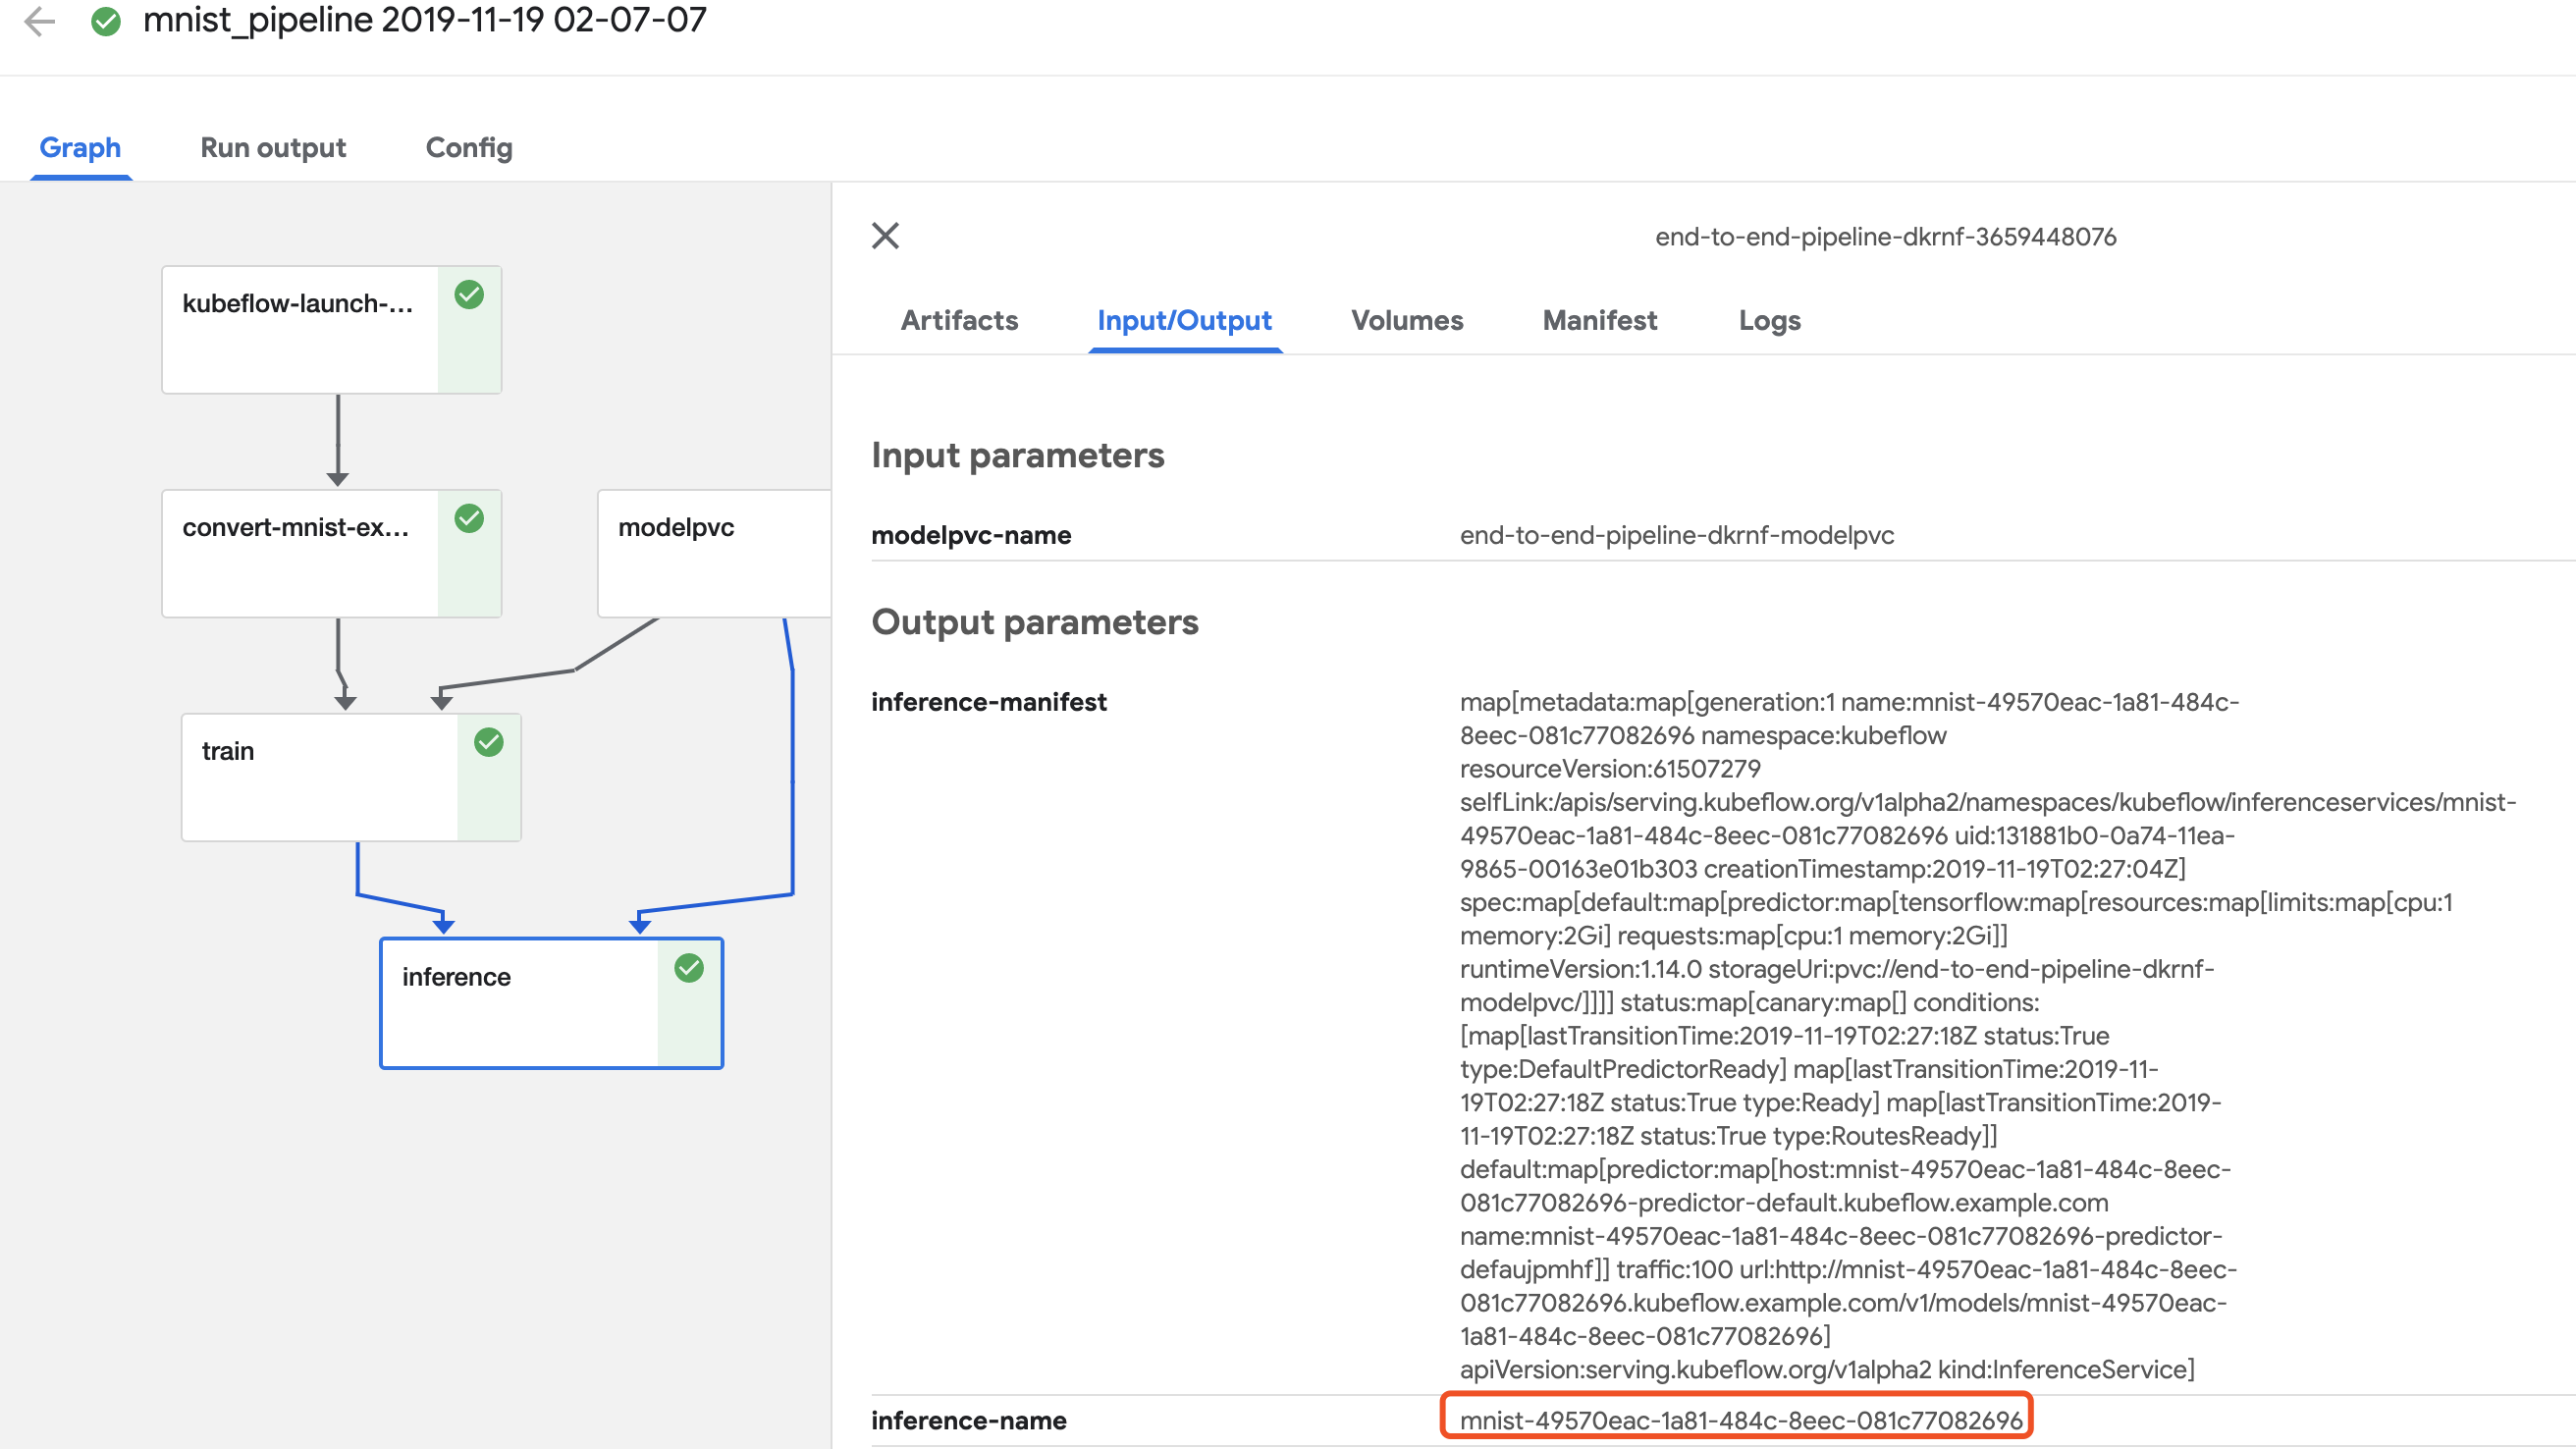

2. Download a mnist picture for inference test, such as 9.bmp from [here](https://raw.githubusercontent.com/hougangliu/pipelines/e2e-pipeline-sample/samples/contrib/e2e-mnist/9.bmp). Then upload it to the notebook.